In [50]:
import pandas as pd
import zipfile

import scipy.stats as stats
import numpy as np
from collections import Counter

# Define the path to the zip file
zip_file_path = './papers_with_concepts_wo_title.csv.zip'

# read 'GDP_PPP_Data_EU.xlsx' into a DataFrame
gdp_ppp_data = pd.read_excel('GDP_PPP_Data_EU.xlsx')

EU_OLD = ['Austria', 'Belgium', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal', 'Spain', 'Sweden']
EU_NEW = ['Croatia', 'Cyprus', 'Czech Republic', 'Estonia', 'Hungary', 'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia']
EU_14 = ['AT', 'BE', 'DE', 'DK', 'ES', 'FI', 'FR', 'GR', 'IE', 'IT', 'LU', 'NL', 'PT', 'SE']
EU_13 = ['CY', 'CZ', 'EE','HR', 'HU', 'LT', 'LV', 'PL', 'SI', 'SK', 'RO']


statistics = []
statistics_gdp = []
for year in range(2009, 2020):
    country_codes = []
    country_code_apc = {}
    apcs = []
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as z:
        # List all files in the zip
        csv_files = [file for file in z.namelist() if file.endswith('.csv')]
        if len(csv_files) != 1:
            raise ValueError('The zip file should contain exactly one CSV file')
        
        # Open the CSV file within the zip file
        with z.open(csv_files[0]) as f:
            # Read the CSV file line by line
            chunk_size = 1000  # Number of rows per chunk
            chunks = pd.read_csv(f, chunksize=chunk_size)

            # Process each chunk
            for chunk in chunks:
                # Process your chunk here
                # print(chunk.head())  # Example: print the first few rows of each chunk
                
                # get rows in chunk
                for index, row in chunk.iterrows():
                    if row['APC'] and row['publication_year'] == year:
                        country_codes.append(row['country_code'])
                        apcs.append(row['APC_in_dollar'])
                        if row['country_code'] in country_code_apc:
                            country_code_apc[row['country_code']] += row['APC_in_dollar']
                        else:
                            country_code_apc[row['country_code']] = row['APC_in_dollar']
    country_code_counter = Counter(country_codes)
    eu14 = []
    eu14_gdp = []
    for cc in EU_14:
        if cc in country_code_counter:
            #print(cc, country_code_apc[cc]/country_code_counter[cc])
            eu14.append(country_code_apc[cc]/country_code_counter[cc])
            #if cc in gdp_ppp_data['Country Code'].values:
            eu14_gdp.append(country_code_apc[cc]/country_code_counter[cc]/gdp_ppp_data[gdp_ppp_data['Country Code'] == cc][year].values[0])
    eu13= []
    eu13_gdp = []
    for cc in EU_13:
        if cc in country_code_counter:
            #print(cc, country_code_apc[cc]/country_code_counter[cc])
            eu13.append(country_code_apc[cc]/country_code_counter[cc])
            #if cc in gdp_ppp_data['Country Code'].values:
            eu13_gdp.append(country_code_apc[cc]/country_code_counter[cc]/gdp_ppp_data[gdp_ppp_data['Country Code'] == cc][year].values[0])

    mann_whitney_u_test = stats.mannwhitneyu(eu14, eu13, alternative='two-sided')
    mann_whitney_u_test_gdp = stats.mannwhitneyu(eu14_gdp, eu13_gdp, alternative='two-sided')
    statistics.append((year, np.mean(eu14), np.std(eu14), np.mean(eu13), np.std(eu13), mann_whitney_u_test))
    statistics_gdp.append((year, np.mean(eu14_gdp), np.std(eu14_gdp), np.mean(eu13_gdp), np.std(eu13_gdp), mann_whitney_u_test_gdp))
    print(statistics[-1])
    print(statistics_gdp[-1])
    

(2009, 1989.257587509357, 232.7832101369359, 1659.1118671432298, 383.0852560731, MannwhitneyuResult(statistic=106.0, pvalue=0.03764795382760189))
(2009, 0.05182377923670709, 0.008865928754118112, 0.07423933914238566, 0.01749925814684011, MannwhitneyuResult(statistic=9.0, pvalue=0.0003963274785936292))
(2010, 1984.6732204364157, 102.49052185410055, 1564.511592706972, 384.42999959435133, MannwhitneyuResult(statistic=116.0, pvalue=0.007717001420083896))
(2010, 0.05120143335292772, 0.010802500955370555, 0.06757877354774722, 0.018375950728900622, MannwhitneyuResult(statistic=32.0, pvalue=0.02810804014715179))
(2011, 2001.27181671757, 154.6665921185355, 1643.2722794970014, 340.5559011774707, MannwhitneyuResult(statistic=114.0, pvalue=0.010862255333717213))
(2011, 0.04997179335459323, 0.010773771245834883, 0.06628434496145005, 0.013669354959170404, MannwhitneyuResult(statistic=20.0, pvalue=0.0037504412848183765))
(2012, 1967.0466250269667, 120.85054467441824, 1774.2092088173274, 235.640567318

In [51]:
sts = []
for s in statistics:
    sts.append([s[0], s[1], s[2], s[3], s[4], s[5].statistic, s[5].pvalue])

sts_gdp = []
for s in statistics_gdp:
    sts_gdp.append([s[0], s[1], s[2], s[3], s[4], s[5].statistic, s[5].pvalue])

np.save('statistics.npy', sts)
np.save('statistics_gdp.npy', sts_gdp)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import matplotlib
%config InlineBackend.figure_format='retina'

statistics = np.load('statistics.npy', allow_pickle=True)
statistics_gdp = np.load('statistics_gdp.npy', allow_pickle=True)

In [6]:
# convert statistics to a dataframe
df = pd.DataFrame(statistics, columns=['year', 'mean_EU14', 'std_EU14', 'mean_EU13', 'std_EU13', 'U', 'p-value'])
df_gdp = pd.DataFrame(statistics_gdp, columns=['year', 'mean_EU14', 'std_EU14', 'mean_EU13', 'std_EU13', 'U', 'p-value'])

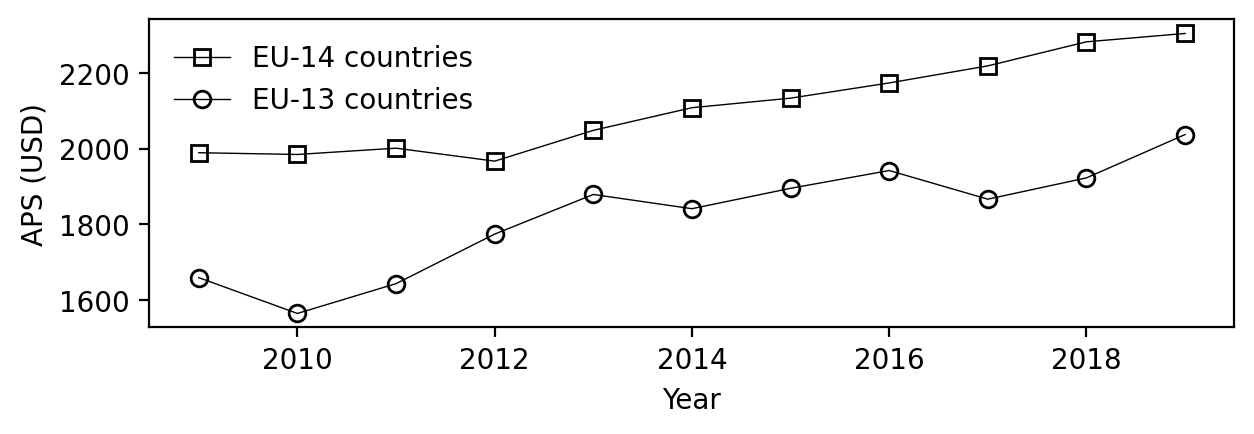

In [15]:
# get mean_EU14 and mean_EU13
mean_EU14 = df['mean_EU14']
mean_EU13 = df['mean_EU13']

# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,mean_EU14,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.plot(year,mean_EU13,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.xlabel('Year')
plt.ylabel('APS (USD)')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
#plt.ylim(0.09,0.51)

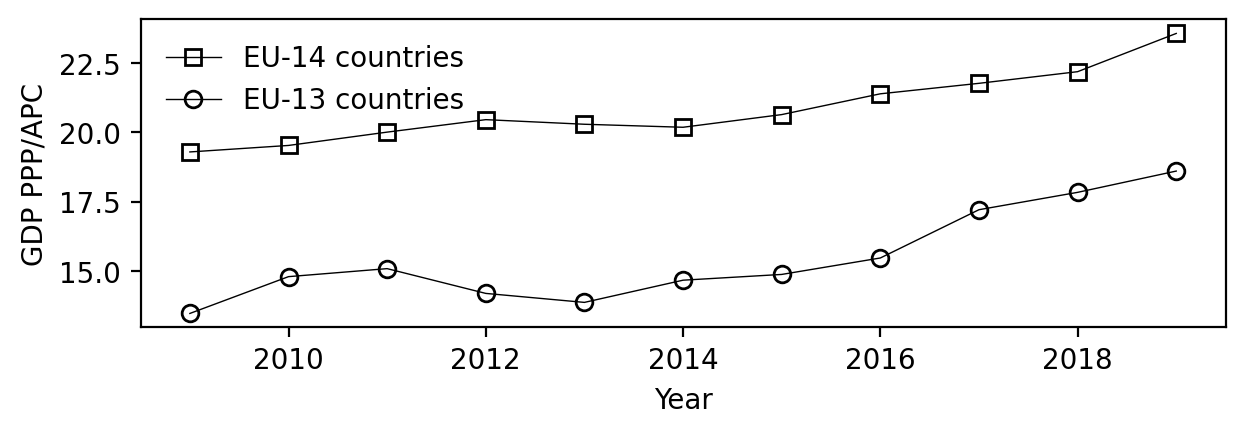

In [20]:
# get mean_EU14 and mean_EU13
mean_EU14 = df_gdp['mean_EU14']
mean_EU13 = df_gdp['mean_EU13']

# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,1/mean_EU14,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="EU-14 countries")
plt.plot(year,1/mean_EU13,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="EU-13 countries")
plt.xlabel('Year')
plt.ylabel('GDP PPP/APC')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='upper left')
#plt.ylim(0.09,0.51)

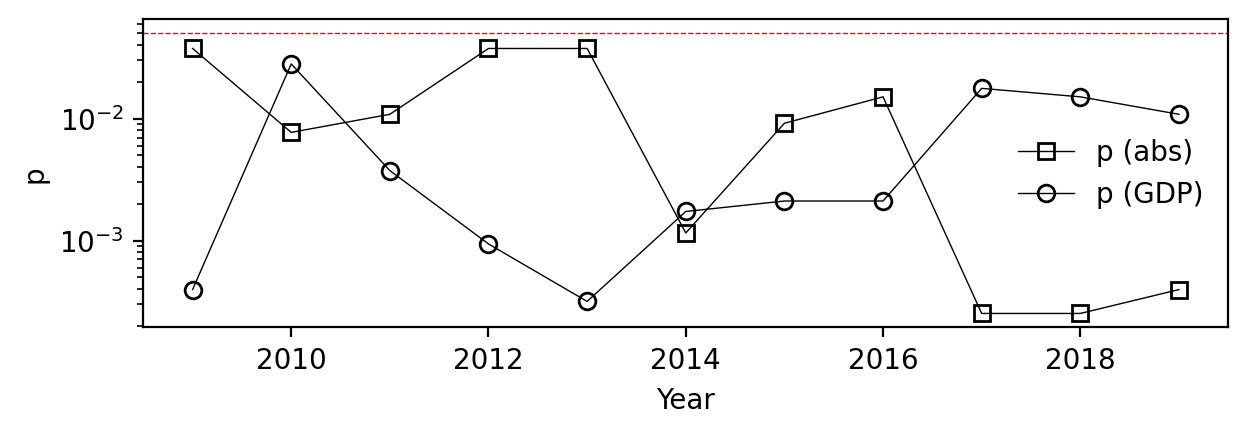

In [30]:
# get mean_EU14 and mean_EU13
p_value = df['p-value']
p_value_gdp = df_gdp['p-value']


# x-axis year
year = df['year']


plt.figure(figsize=(7, 2))
plt.plot(year,p_value,marker='s',color="black",ms=6, ls='-', mfc='none',lw=0.5, label="p (abs)")
plt.plot(year,p_value_gdp,marker='.',color="black",ms=12, ls='-', mfc='none',lw=0.5, label="p (GDP)")
plt.xlabel('Year')
plt.ylabel('p')
# plot legend without frame, place it in the upper left corner
plt.legend(frameon=False, loc='best')
#plt.ylim(0.09,0.51)
plt.yscale('log')
# plot horizontal line at y=0.05
plt.axhline(y=0.05, color='r', linestyle='--',lw=0.5)